<a href="https://colab.research.google.com/github/CarOmodeo/practicos_pnl/blob/main/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio 4: LSTM Bot QA

## Alumno: Carolina Pérez Omodeo

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Recomendaciones:

* MAX_VOCAB_SIZE = 8000
* max_length ~ 10
* Embeddings 300 Fasttext
* n_units = 128
* LSTM Dropout 0.2
* Epochs 30~50

Preguntas interesantes:

* Do you read?
* Do you have any pet?
* Where are you from?

IMPORTANTE: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 136MB/s]


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [4]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5985


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [7]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [10]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=1783)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1783
Sentencia de entrada más larga: 9


In [11]:
# Tokenización para las salidas (respuestas)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida
print("Número de palabras de salida:", num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1794
Número de palabras de salida: 1795
Sentencia de salida más larga: 10


A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [12]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

# Padding de las secuencias
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 5985
encoder_input_sequences shape: (5985, 9)
decoder_input_sequences shape: (5985, 10)


In [13]:
print(np.max(encoder_input_sequences))

1782


La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [14]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
# Crear los targets para el decoder (one-hot encoding)
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)

decoder_targets shape: (5985, 10, 1795)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
# descargamos los embeddings de palabras de Fasttext para inglés y descomprimimos el archivo.
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2024-12-17 21:02:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  65.6MB/s    in 6.6s    

2024-12-17 21:02:46 (99.3 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [16]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'wiki-news-300d-1M.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

#### FastText

In [17]:
model_embeddings = FasttextEmbeddings()

In [18]:
# Preparar las matrices de embeddings para encoder y decoder
print('preparing embedding matrices...')

embed_dim = model_embeddings.N_FEATURES  # Dimensión de los embeddings (300 para FastText)
words_not_found_encoder = []
words_not_found_decoder = []

# Crear la matriz de embeddings para el encoder
nb_words_encoder = min(MAX_VOCAB_SIZE, len(word2idx_inputs))  # vocab_size del encoder
embedding_matrix_encoder = np.zeros((nb_words_encoder, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words_encoder:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if embedding_vector is not None and len(embedding_vector) > 0:
        embedding_matrix_encoder[i] = embedding_vector
    else:
        words_not_found_encoder.append(word)

# Crear la matriz de embeddings para el decoder
nb_words_decoder = num_words_output  # vocab_size del decoder
embedding_matrix_decoder = np.zeros((nb_words_decoder, embed_dim))
for word, i in word2idx_outputs.items():
    if i >= nb_words_decoder:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if embedding_vector is not None and len(embedding_vector) > 0:
        embedding_matrix_decoder[i] = embedding_vector
    else:
        words_not_found_decoder.append(word)

# Mostrar el número de palabras que no se encontraron en los embeddings
print('Number of null word embeddings in encoder:', np.sum(np.sum(embedding_matrix_encoder**2, axis=1) == 0))
print('Number of null word embeddings in decoder:', np.sum(np.sum(embedding_matrix_decoder**2, axis=1) == 0))

# Si lo deseas, también puedes imprimir las palabras que no se encontraron
print(f"Words not found in encoder embeddings: {words_not_found_encoder[:10]}")  # Muestra las primeras 10
print(f"Words not found in decoder embeddings: {words_not_found_decoder[:10]}")  # Muestra las primeras 10


preparing embedding matrices...
Number of null word embeddings in encoder: 1
Number of null word embeddings in decoder: 1
Words not found in encoder embeddings: []
Words not found in decoder embeddings: []


In [19]:
# Dimensión de los embeddings de la secuencia en inglés
print("embedding_matrix_encoder shape: ", embedding_matrix_encoder.shape)
print("embedding_matrix_decoder shape: ", embedding_matrix_decoder.shape)

embedding_matrix_encoder shape:  (1783, 300)
embedding_matrix_decoder shape:  (1795, 300)


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words_encoder,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix_encoder],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding_layer = Embedding(
          input_dim=nb_words_decoder,          # tamaño del vocabulario del decoder
          output_dim=embed_dim,                # dimensión de embeddings (300 para FastText)
          input_length=max_out_len,            # longitud máxima de la secuencia de salida
          weights=[embedding_matrix_decoder],  # matriz de embeddings de FastText
          trainable=False)                     # no entrenar embeddings

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 9, 300)         │        534,900 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 10, 300)        │        538,500 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │        219,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 10, 128),      │        219,648 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 1795)       │        231,555 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,744,251 (6.65 MB)

 Trainable params: 670,851 (2.56 MB)

 Non-trainable params: 1,073,400 (4.09 MB)

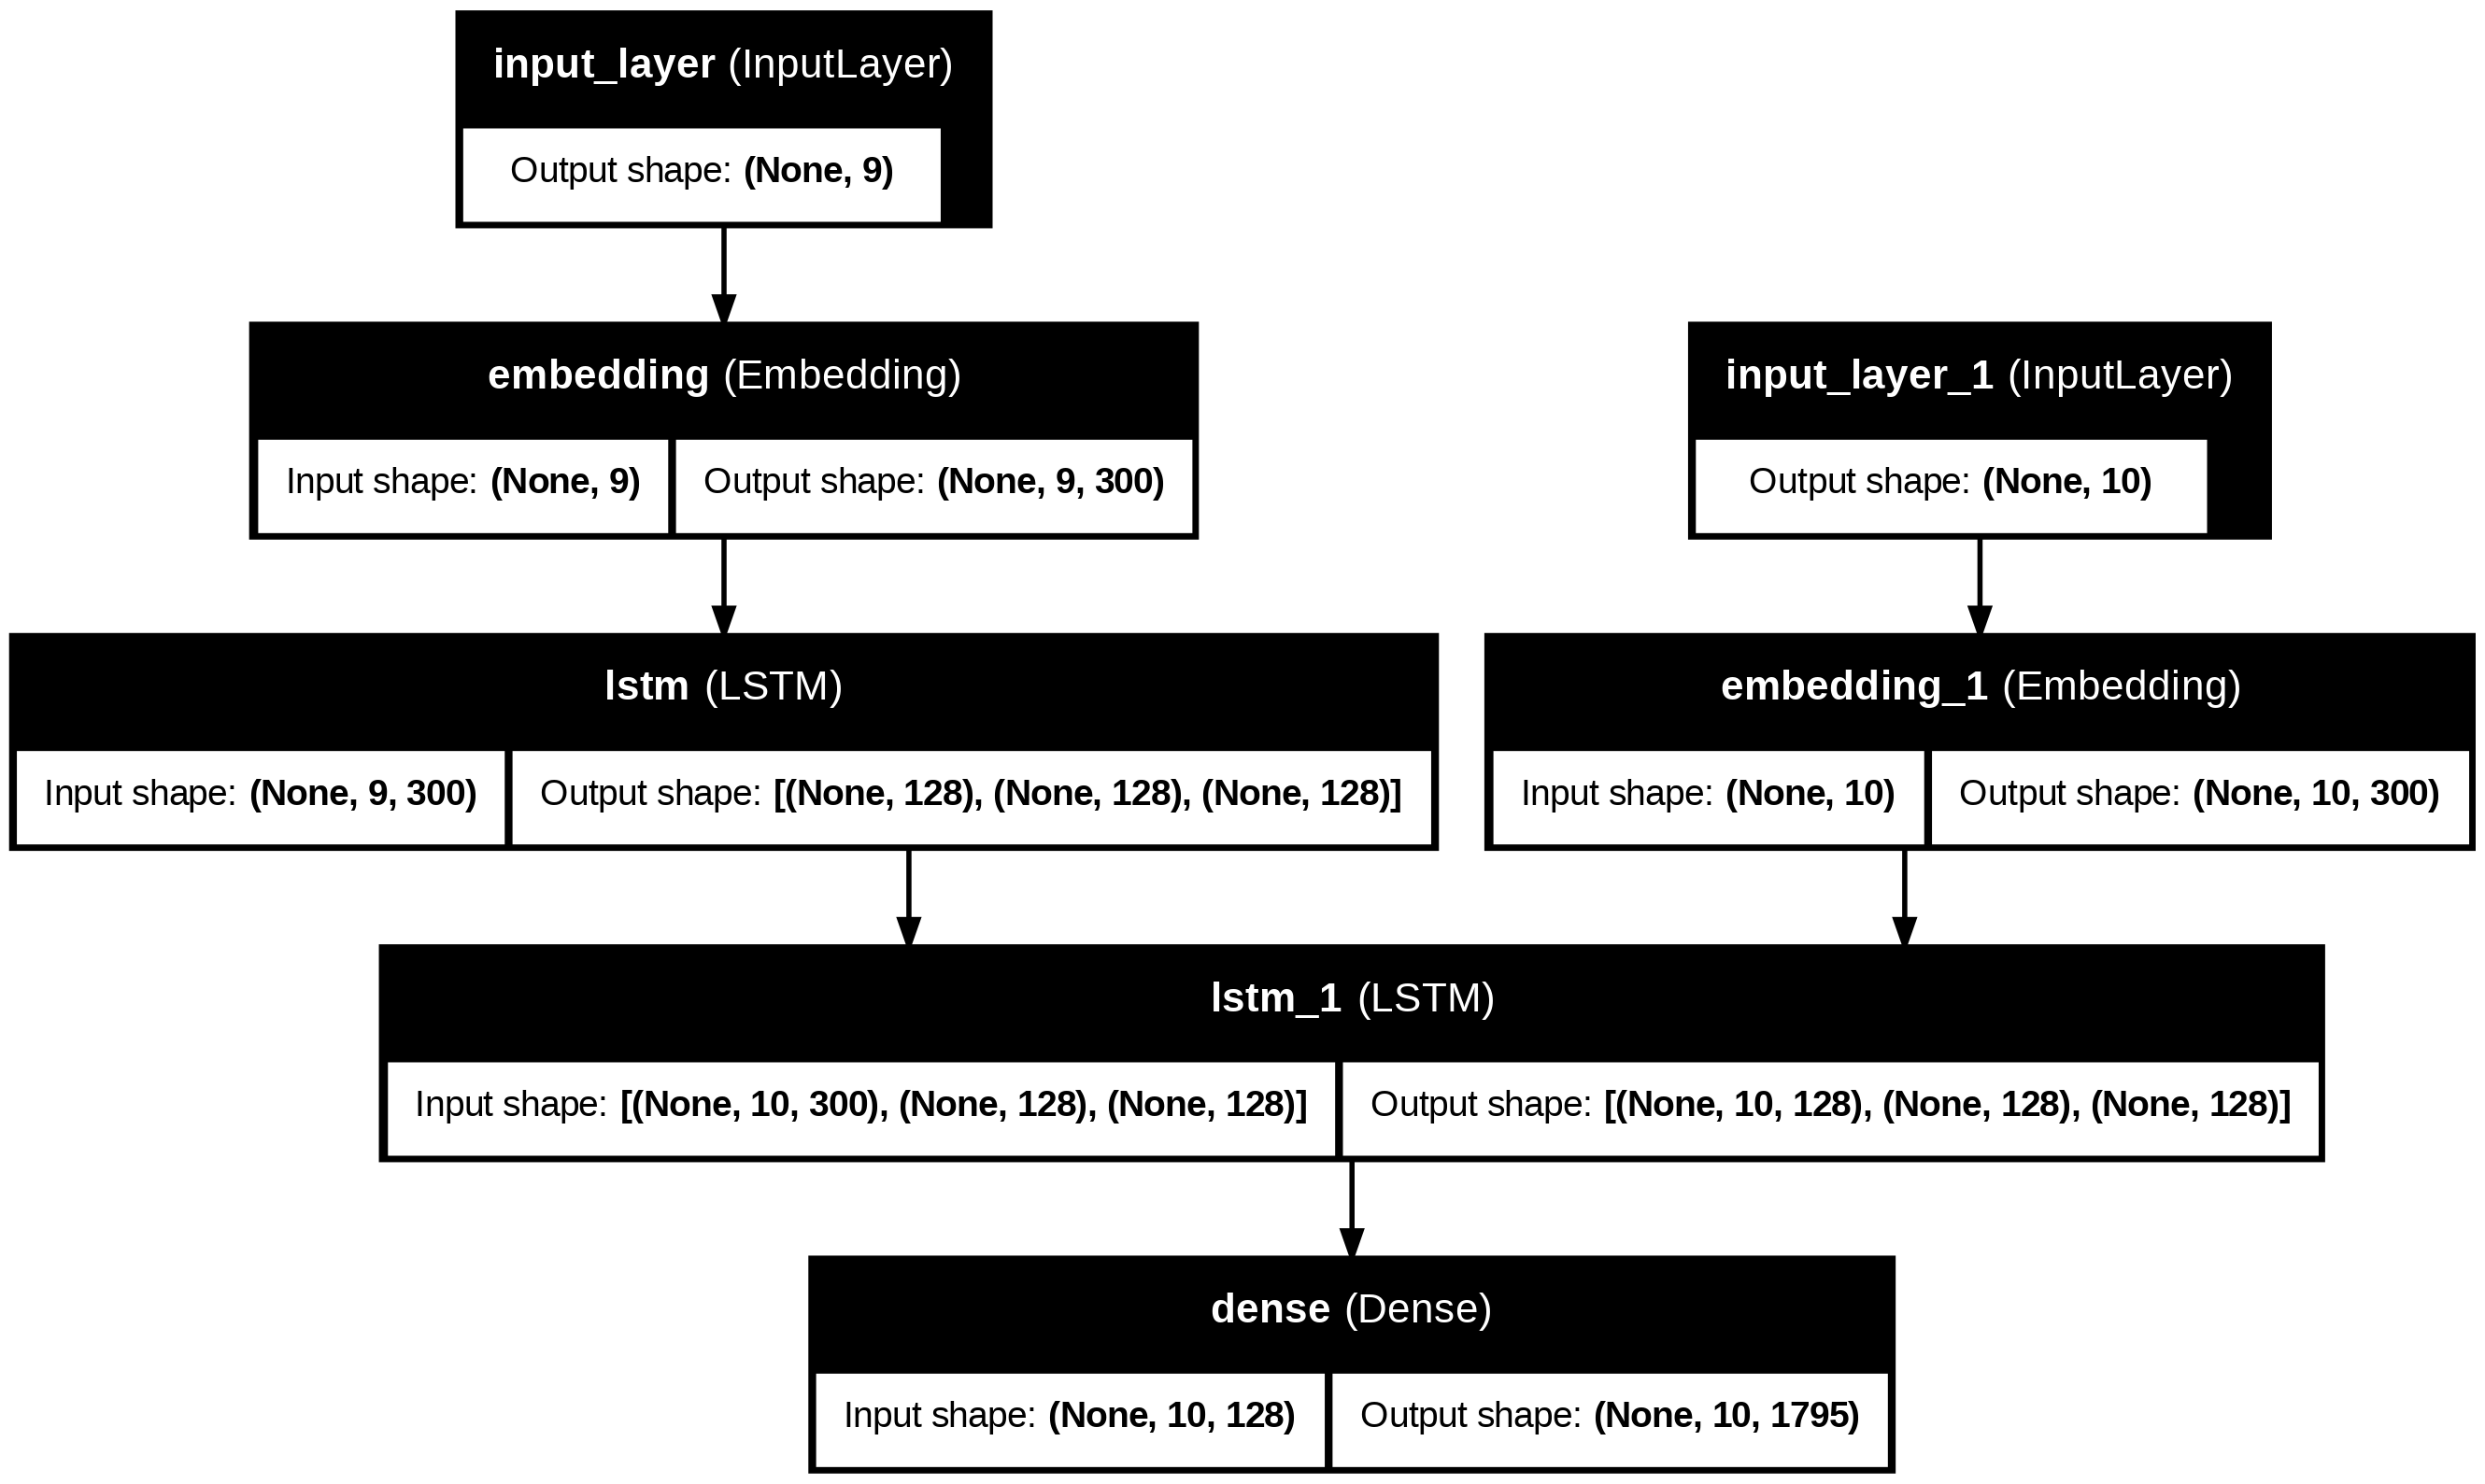

In [21]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

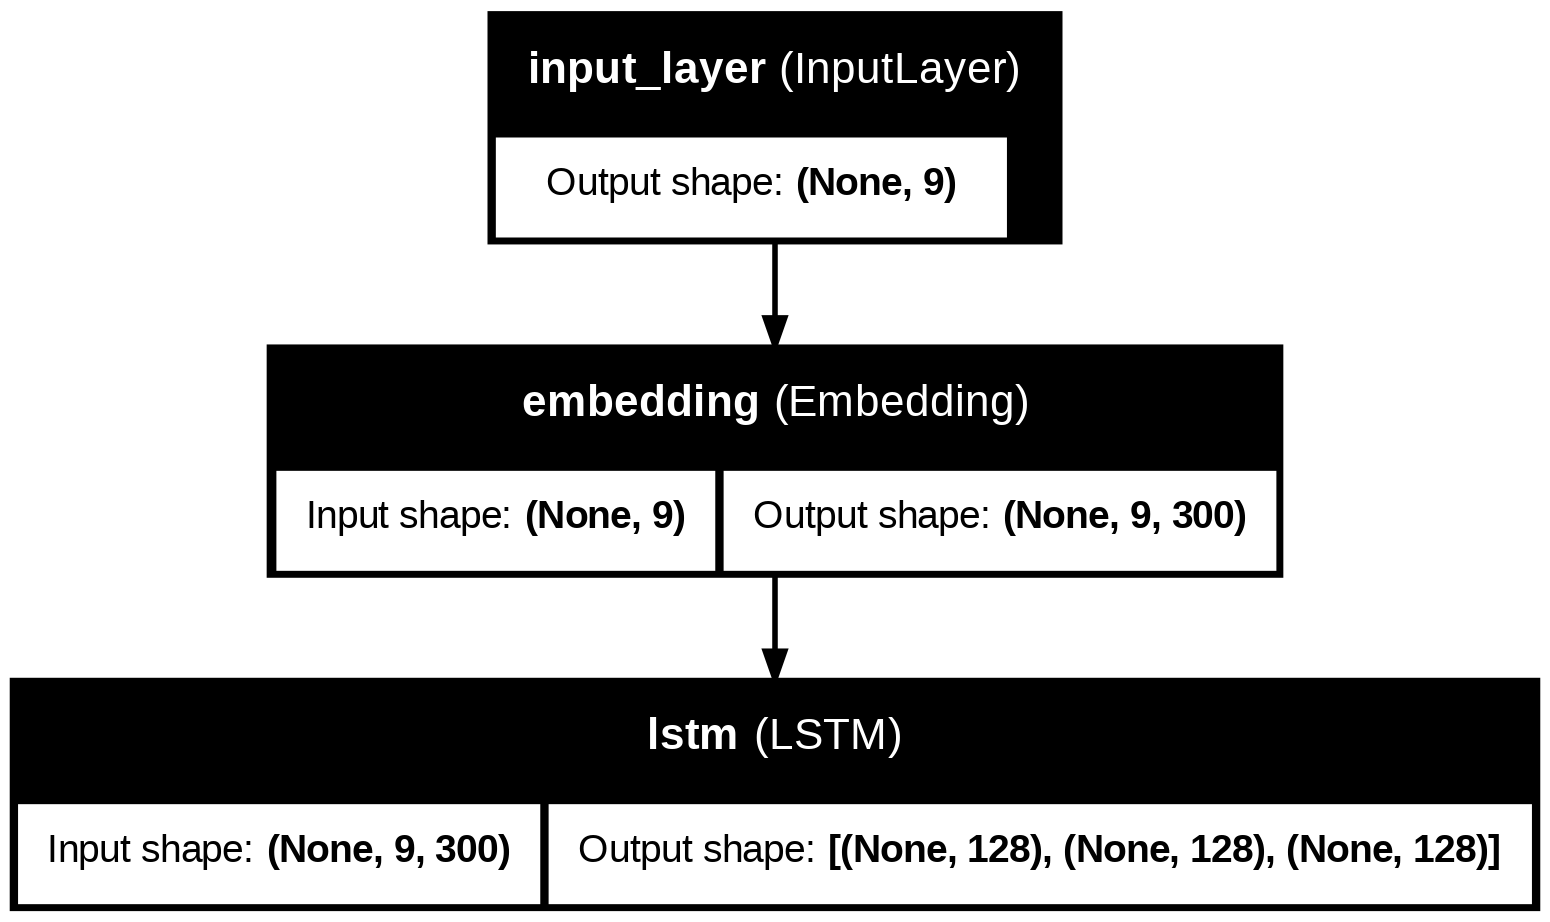

In [22]:
# --- Definir el modelo del Encoder para la Inferencia ---

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

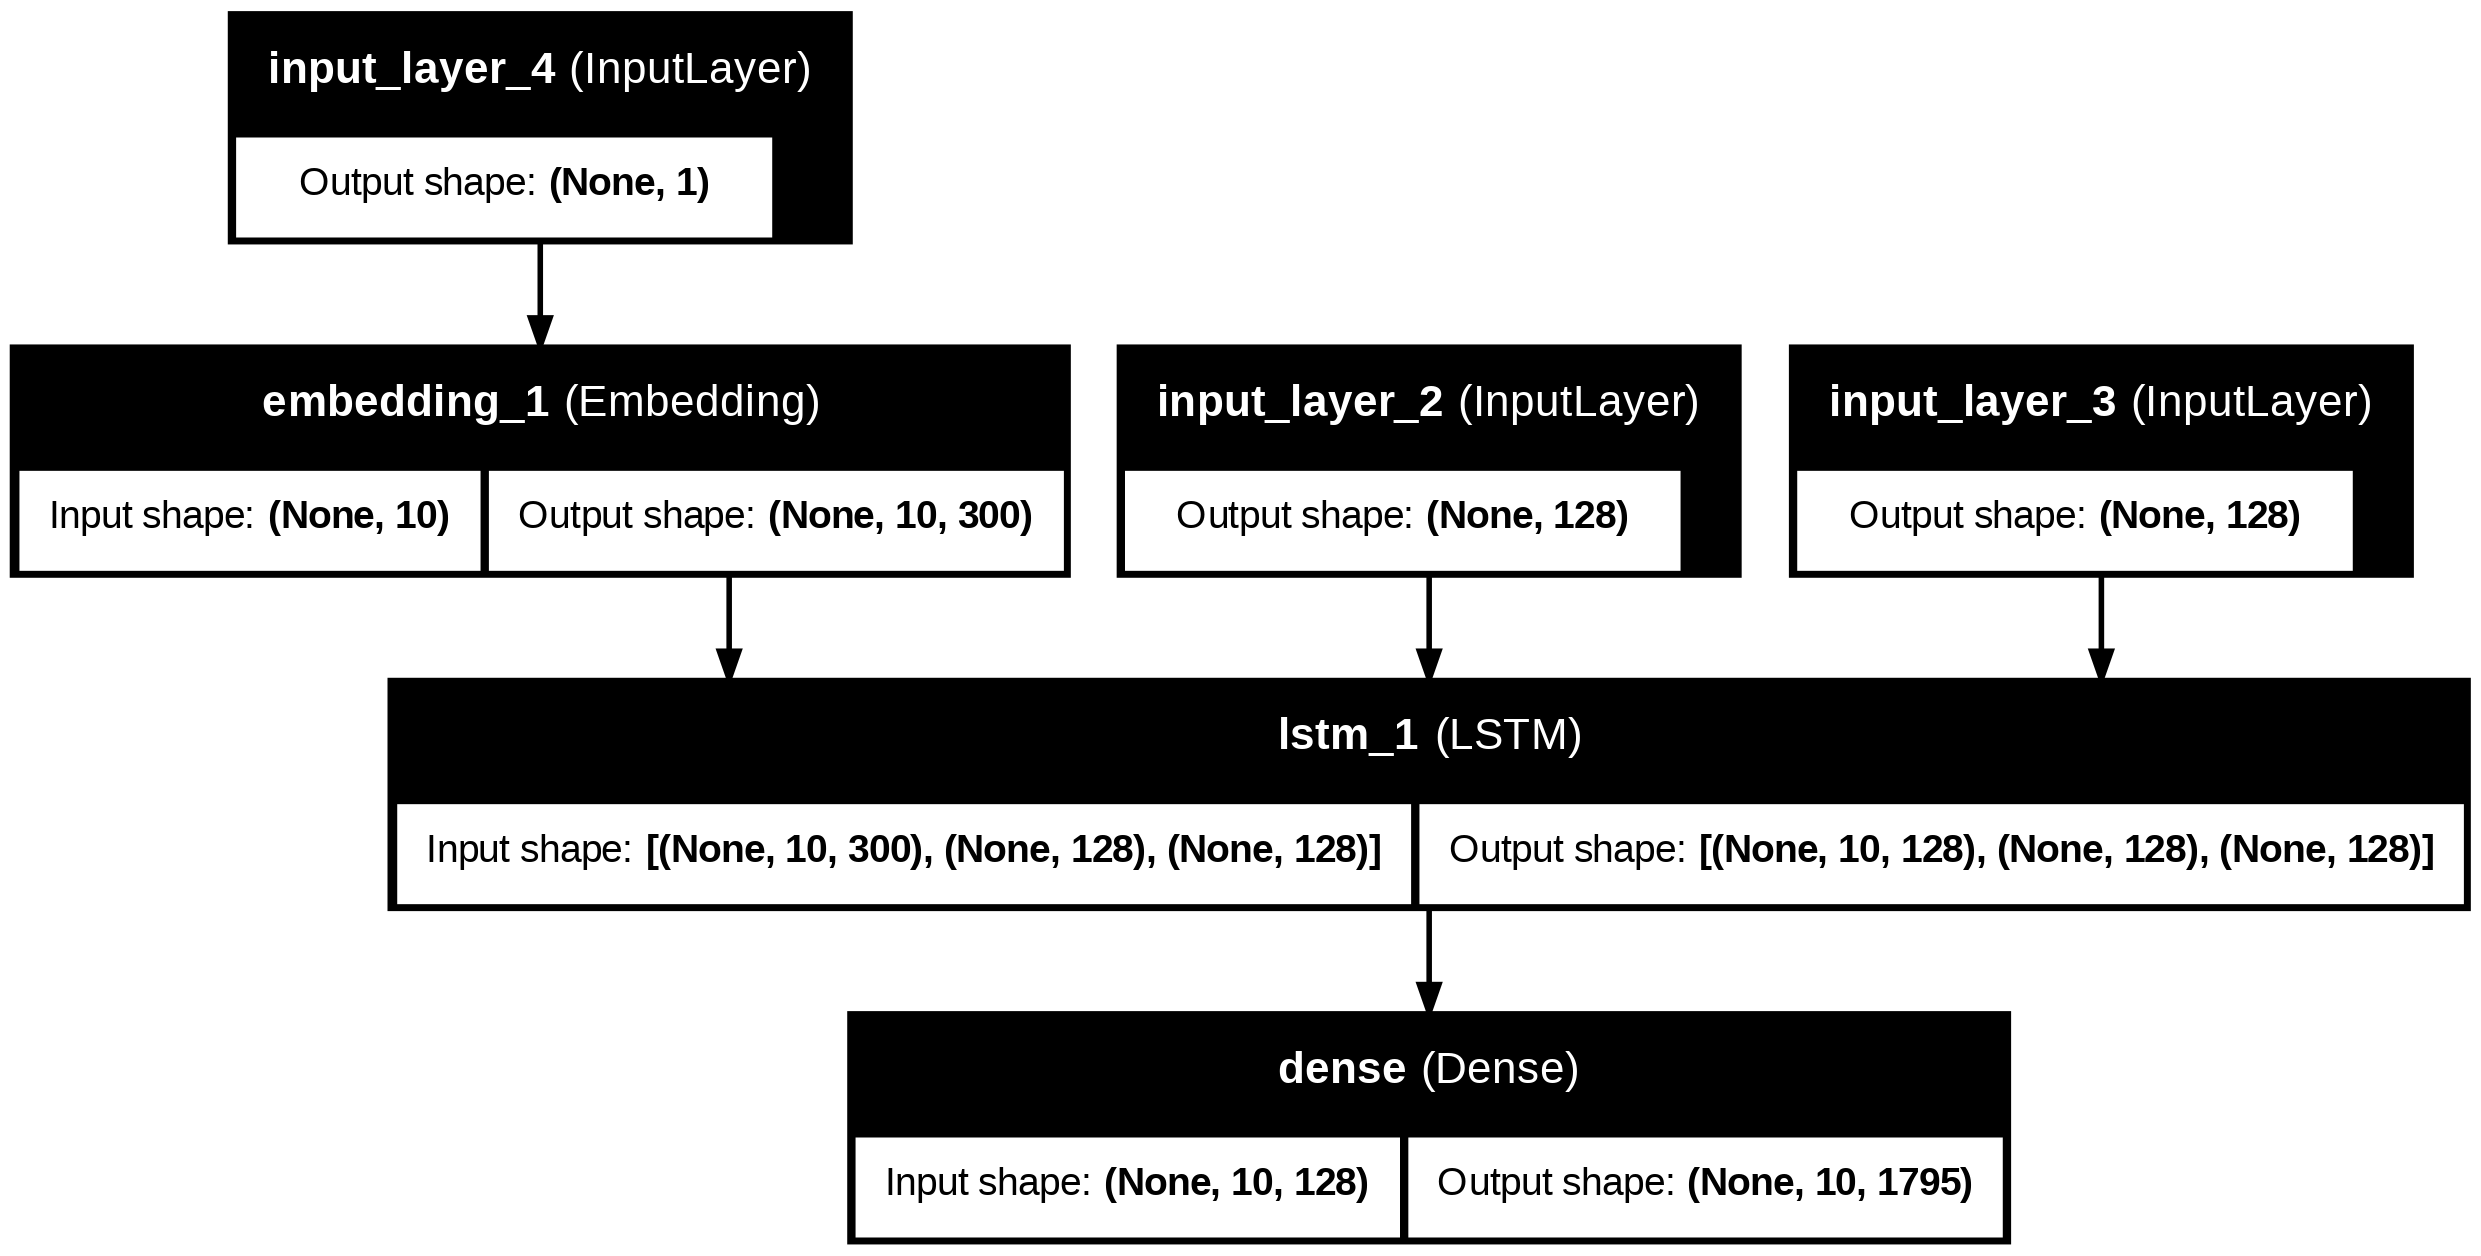

In [23]:
# --- Definir el modelo del Decoder para la Inferencia ---

decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=40,
    validation_split=0.2)

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.4698 - loss: 4.2924 - val_accuracy: 0.6146 - val_loss: 2.2998
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.6201 - loss: 2.1296 - val_accuracy: 0.6592 - val_loss: 2.0815
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.6682 - loss: 1.8571 - val_accuracy: 0.6810 - val_loss: 1.9555
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.7009 - loss: 1.7141 - val_accuracy: 0.6855 - val_loss: 1.8929
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.7093 - loss: 1.6252 - val_accuracy: 0.6935 - val_loss: 1.8603
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7178 - loss: 1.5526 - val_accuracy: 0.6985 - val_loss: 1.8308
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.7207 - loss: 1.5331 - val_accuracy: 0.6981 - val_loss: 1.8225
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.7239 - loss: 1.4

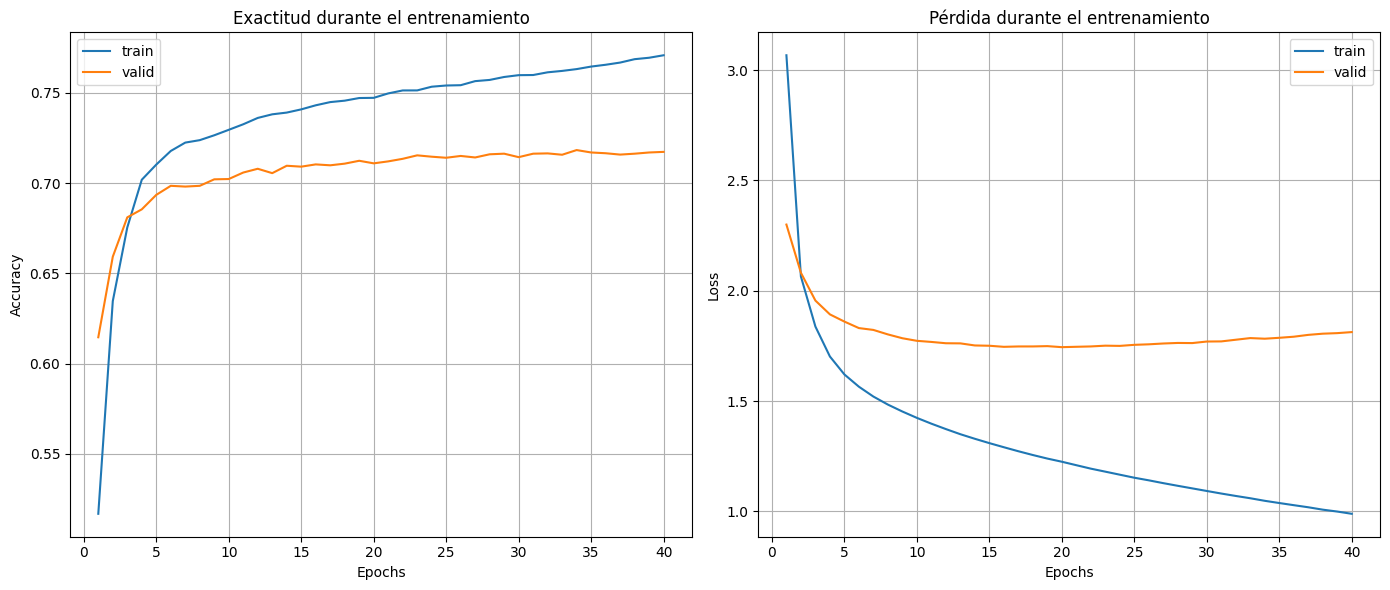

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: Precisión
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='train', ax=axes[0])
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='valid', ax=axes[0])
axes[0].set_title('Exactitud durante el entrenamiento')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

# Segundo gráfico: Pérdida
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['loss'], label='train', ax=axes[1])
sns.lineplot(x=epoch_count, y=hist.history['val_loss'], label='valid', ax=axes[1])
axes[1].set_title('Pérdida durante el entrenamiento')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()

# Mostrar las gráficas
plt.show()


Del gráfico se puede observar que:

1. **Exactitud:** La precisión en el conjunto de entrenamiento aumenta de manera constante durante las 40 épocas, alcanzando aproximadamente 0.77. Sin embargo, en el conjunto de validación, la precisión se estabiliza alrededor de 0.71 después de las primeras 10 épocas.
Esto sugiere que el modelo sigue ajustándose al conjunto de entrenamiento, pero no mejora en validación, lo que podría indicar sobreajuste a partir de cierto punto.
2. **Pérdida:** La pérdida del conjunto de entrenamiento disminuye de manera constante hasta aproximadamente 1.0. Por otro lado, la pérdida en validación alcanza un mínimo en las primeras épocas y luego se mantiene constante alrededor de 2.0, mostrando que no mejora significativamente.

En conclusión, el modelo aprende bien en entrenamiento, pero no generaliza de manera óptima.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [27]:
import numpy as np

# --- Función para Decodificar una Secuencia ---

def decode_sequence(input_seq):
    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Generar una secuencia de inicio con el token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Almacenar la secuencia generada
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Obtener las predicciones del decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Índice de la palabra con mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = None

        # Buscar la palabra correspondiente al índice
        for word, index in word2idx_outputs.items():
            if sampled_token_index == index:
                sampled_word = word
                break

        # Si no se encuentra palabra, detener
        if sampled_word is None:
            break

        # Agregar la palabra a la secuencia generada
        decoded_sentence += ' ' + sampled_word

        # Detener si se alcanza el token <eos> o la longitud máxima
        if sampled_word == '<eos>' or len(decoded_sentence.split()) >= max_input_len:
            stop_condition = True

        # Actualizar la secuencia de entrada del decoder
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados del decoder
        states_value = [h, c]

    return decoded_sentence.strip()

# --- Preguntas de Ejemplo para la Inferencia ---

example_questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?"
]

# Preprocesar las preguntas (limpiar y tokenizar)
def preprocess_question(question):
    question = clean_text(question)  # Usar la función de limpieza previamente definida
    sequence = input_tokenizer.texts_to_sequences([question])
    return pad_sequences(sequence, maxlen=max_input_len, padding='post')


# Generar respuestas para las preguntas de ejemplo
for question in example_questions:
    input_sequence = preprocess_question(question)
    print(input)
    print(f"Pregunta original: {question}")
    print(f"Pregunta preprocesada: {clean_text(question)}")

    # Decodificar la secuencia y generar la respuesta
    decoded_sentence = decode_sequence(input_sequence)
    print(f"Respuesta Generada: {decoded_sentence}")
    print("-" * 50)



<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7d9230172140>>
Pregunta original: Do you read?
Pregunta preprocesada: do you read 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Respuesta Generada: i love to read <eos>
--------------------------------------------------
<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7d9230172140>>
Pregunta original: Do you have any pet?
Pregunta preprocesada: do you have any pet 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Respuesta Generada: i am a girl <eos>
--------------------------------------------------
<bound method Kernel.raw_input 

Los resultados de las inferencias muestran un desempeño limitado del modelo en la generación de respuestas coherentes y contextualmente apropiadas. Si bien las preguntas preprocesadas se presentan de manera clara y adecuada, las respuestas generadas no reflejan una correspondencia directa con las preguntas originales.

Al analizar las respuestas:

* Para la pregunta **"Do you read?"**, la respuesta generada **"I love to read"** es coherente y relevante, lo que sugiere que el modelo puede proporcionar respuestas acertadas en algunos casos.
* Para la pregunta **"Do you have any pet?"**, la respuesta generada **"I am a girl"** es incorrecta y no relacionada con el contenido de la pregunta, lo cual evidencia dificultades en la comprensión del contexto, pero se puede destacar que la respuesta tiene coherencia en si misma.
* Para la pregunta **"Where are you from?"**, la respuesta **"I love to read"** se repite, mostrando que el modelo tiende a generar respuestas repetitivas y genéricas, sin adaptarse al significado de la pregunta.

Este comportamiento indica que el modelo presenta limitaciones en:

La capacidad de entender el significado semántico de la entrada.
La generalización de respuestas apropiadas a nuevas preguntas.
La diversidad en las respuestas, tendiendo a repetir frases previamente generadas.
En conclusión, el modelo puede producir respuestas coherentes en casos simples o entrenados, pero aún carece de precisión y capacidad contextual para preguntas más variadas. Es necesario ajustar la arquitectura, entrenar con un conjunto de datos más extenso o aplicar técnicas para mejorar su rendimiento.

### Conclusión

El modelo logra aprender de manera efectiva durante el entrenamiento, como lo demuestra la mejora constante en las métricas de exactitud y pérdida. No obstante, el estancamiento en los resultados de validación revela un problema de sobreajuste, lo cual limita su capacidad de generalización a nuevos datos.

Al evaluar los resultados de las inferencias, se observó que, aunque el modelo puede generar respuestas coherentes y relevantes en casos simples, presenta dificultades para comprender preguntas más complejas o variadas. Esto se refleja en respuestas repetitivas y no relacionadas con el contexto de la pregunta, indicando una limitación en la capacidad del modelo para manejar la semántica y adaptarse a diferentes entradas.

Para mejorar su rendimiento, se recomienda aplicar técnicas de regularización, optimizar hiperparámetros y ajustar la arquitectura del modelo. También, sería beneficioso ampliar el conjunto de datos de entrenamiento.

En general, el desempeño actual del modelo es una base aceptable, pero presenta un margen considerable de mejora para su implementación práctica en tareas de procesamiento del lenguaje natural.